<a href="https://colab.research.google.com/github/venomouscyanide/ExtendoScaLed/blob/main/experimentations/Examining_Operators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html


In [ ]:
# Standalone code that helps examine Golden/Beagle Operator Matrices as graphs
import os
import random

import torch
from networkx import Graph
from scipy.sparse import SparseEfficiencyWarning
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.utils import coalesce, add_self_loops, negative_sampling, train_test_split_edges, to_dense_adj, \
    to_networkx
from torch_sparse import SparseTensor
import scipy.sparse as ssp
from tqdm import tqdm
import networkx as nx

import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.transforms import SIGN

import warnings

In [ ]:
# supress all warnings
warnings.simplefilter('ignore', SparseEfficiencyWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

# Modified code from ScaLed to incooporate SIGN operators.

Only major change in code for Colab is that only 25% of edges are considered due to RAM constraints. 

In [ ]:
def do_edge_split(dataset, fast_split=False, val_ratio=0.05, test_ratio=0.1, neg_ratio=1, data_passed=False):
    if not data_passed:
        data = dataset[0]
    else:
        # for flow involving SEAL datasets, we pass data in dataset arg directly
        data = dataset

    data = train_test_split_edges(data, val_ratio, test_ratio)
    edge_index, _ = add_self_loops(data.train_pos_edge_index)
    data.train_neg_edge_index = negative_sampling(
        edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1) * neg_ratio)

    split_edge = {'train': {}, 'valid': {}, 'test': {}}
    split_edge['train']['edge'] = data.train_pos_edge_index.t()
    split_edge['train']['edge_neg'] = data.train_neg_edge_index.t()
    split_edge['valid']['edge'] = data.val_pos_edge_index.t()
    split_edge['valid']['edge_neg'] = data.val_neg_edge_index.t()
    split_edge['test']['edge'] = data.test_pos_edge_index.t()
    split_edge['test']['edge_neg'] = data.test_neg_edge_index.t()
    return split_edge


def get_pos_neg_edges(split, split_edge, edge_index, num_nodes, percent=100, neg_ratio=1):
    pos_edge = split_edge[split]['edge'].t()
    if split == 'train':
        new_edge_index, _ = add_self_loops(edge_index)
        neg_edge = negative_sampling(
            new_edge_index, num_nodes=num_nodes,
            num_neg_samples=pos_edge.size(1) * neg_ratio)
    else:
        neg_edge = split_edge[split]['edge_neg'].t()
    # subsample for pos_edge
    num_pos = pos_edge.size(1)
    perm = np.random.permutation(num_pos)
    perm = perm[:int(percent / 100 * num_pos)]
    pos_edge = pos_edge[:, perm]
    # subsample for neg_edge
    num_neg = neg_edge.size(1)
    perm = np.random.permutation(num_neg)
    perm = perm[:int(percent / 100 * num_neg)]
    neg_edge = neg_edge[:, perm]

    return pos_edge, neg_edge


def neighbors(fringe, A, outgoing=True):
    # Find all 1-hop neighbors of nodes in fringe from graph A,
    # where A is a scipy csr adjacency matrix.
    # If outgoing=True, find neighbors with outgoing edges;
    # otherwise, find neighbors with incoming edges (you should
    # provide a csc matrix in this case).
    if outgoing:
        res = set(A[list(fringe)].indices)
    else:
        res = set(A[:, list(fringe)].indices)

    return res


class TunedSIGN(SIGN):
    """
    Helps pop the keys that are not consumed during training
    """

    def __call__(self, data, sign_k):
        data = super().__call__(data)
        if sign_k == -1:
            for idx in range(1, self.K):
                data.pop(f'x{idx}')
        return data


def k_hop_subgraph(src, dst, num_hops, A, sample_ratio=1.0,
                   max_nodes_per_hop=None, node_features=None,
                   y=1, directed=False, A_csc=None, rw_kwargs=None):
    # Extract the k-hop enclosing subgraph around link (src, dst) from A.
    nodes = [src, dst]
    dists = [0, 0]
    visited = set([src, dst])
    fringe = set([src, dst])
    for dist in range(1, num_hops + 1):
        if not directed:
            fringe = neighbors(fringe, A)
        else:
            out_neighbors = neighbors(fringe, A)
            in_neighbors = neighbors(fringe, A_csc, False)
            fringe = out_neighbors.union(in_neighbors)
        fringe = fringe - visited
        visited = visited.union(fringe)
        if sample_ratio < 1.0:
            fringe = random.sample(fringe, int(sample_ratio * len(fringe)))
        if max_nodes_per_hop is not None:
            if max_nodes_per_hop < len(fringe):
                fringe = random.sample(fringe, max_nodes_per_hop)
        if len(fringe) == 0:
            break
        nodes = nodes + list(fringe)
        dists = dists + [dist] * len(fringe)

    subgraph = A[nodes, :][:, nodes]

    # Remove target link between the subgraph.
    subgraph[0, 1] = 0
    subgraph[1, 0] = 0

    if node_features is not None:
        node_features = node_features[nodes]

    return nodes, subgraph, dists, node_features, y


def construct_pyg_graph(node_ids, adj, dists, node_features, y, node_label='drnl', sign_pyg_kwargs=None):
    # Construct a pytorch_geometric graph from a scipy csr adjacency matrix.
    u, v, r = ssp.find(adj)
    num_nodes = adj.shape[0]

    node_ids = torch.LongTensor(node_ids)
    u, v = torch.LongTensor(u), torch.LongTensor(v)
    r = torch.LongTensor(r)
    edge_index = torch.stack([u, v], 0)
    edge_weight = r.to(torch.float)
    y = torch.tensor([y])

    z = (torch.tensor(dists) == 0).to(torch.long)
    if sign_pyg_kwargs:
        # SIGN PyG graph construction flow
        if sign_pyg_kwargs['use_feature'] and node_features is not None:
            node_features = torch.cat([z.reshape(z.size()[0], 1), node_features.to(torch.float)], -1)
        else:
            # flow never really enters here due to check in main()
            node_features = z
        data = Data(node_features, edge_index, edge_weight=edge_weight, y=y, node_id=node_ids, num_nodes=num_nodes)
    else:
        data = Data(node_features, edge_index, edge_weight=edge_weight, y=y, z=z,
                    node_id=node_ids, num_nodes=num_nodes)
    return data


def extract_enclosing_subgraphs(link_index, A, x, y, num_hops, node_label='zo',
                                ratio_per_hop=1.0, max_nodes_per_hop=None,
                                directed=False, A_csc=None, rw_kwargs=None, sign_kwargs=None, powers_of_A=None,
                                data=None):
    # Extract enclosing subgraphs from A for all links in link_index.
    data_list = []
    for src, dst in tqdm(link_index.t().tolist()):
        num_hops = 1  # restrict to 1, then taken powers of A

        if not powers_of_A:
            # golden flow

            # debug code with graphistry
            # networkx_G = to_networkx(data)  # the full graph
            # graphistry.bind(source='src', destination='dst', node='nodeid').plot(networkx_G)
            # check against the nodes that is received in tmp before the relabeling occurs

            tmp = k_hop_subgraph(src, dst, num_hops, A, ratio_per_hop,
                                 max_nodes_per_hop, node_features=x, y=y,
                                 directed=directed, A_csc=A_csc)

            sign_pyg_kwargs = {
                'use_feature': sign_kwargs['use_feature'],
            }

            data = construct_pyg_graph(*tmp, node_label, sign_pyg_kwargs)

            sign_t = TunedSIGN(sign_kwargs['sign_k'])
            data = sign_t(data, sign_kwargs['sign_k'])

            data_list.append(data)
        else:
            # beagle flow

            # debug code with graphistry
            # networkx_G = to_networkx(data)  # the full graph
            # graphistry.bind(source='src', destination='dst', node='nodeid').plot(networkx_G)
            # check against the nodes that is received in tmp before the relabeling occurs

            for index, power_of_a in enumerate(powers_of_A, start=1):
                tmp = k_hop_subgraph(src, dst, num_hops, power_of_a, ratio_per_hop,
                                     max_nodes_per_hop, node_features=x, y=y,
                                     directed=directed, A_csc=A_csc)
                sign_pyg_kwargs = {
                    'use_feature': sign_kwargs['use_feature'],
                }

                data = construct_pyg_graph(*tmp, node_label, sign_pyg_kwargs)

                sign_t = TunedSIGN(1)
                data = sign_t(data, 1)
                data.operator_index = index

                data_list.append(data)

    return data_list


class SEALDataset(InMemoryDataset):
    def __init__(self, root, data, split_edge, num_hops, sign_k, percent=25, split='train',
                 use_coalesce=False, node_label='drnl', ratio_per_hop=1.0,
                 max_nodes_per_hop=None, directed=False, rw_kwargs=None, device='cpu', pairwise=False,
                 pos_pairwise=False, neg_ratio=1, use_feature=False, args=None, include_negative_samples=False,
                 sign_type='golden'):
        # TODO: avoid args, use the exact arguments instead
        self.data = data
        self.split_edge = split_edge
        self.num_hops = num_hops
        self.percent = int(percent) if percent >= 1.0 else percent
        self.split = split
        self.use_coalesce = use_coalesce
        self.node_label = node_label
        self.ratio_per_hop = ratio_per_hop
        self.max_nodes_per_hop = max_nodes_per_hop
        self.directed = directed
        self.device = device
        self.N = self.data.num_nodes
        self.E = self.data.edge_index.size()[-1]
        self.sparse_adj = SparseTensor(
            row=self.data.edge_index[0].to(self.device), col=self.data.edge_index[1].to(self.device),
            value=torch.arange(self.E, device=self.device),
            sparse_sizes=(self.N, self.N))
        self.rw_kwargs = rw_kwargs
        self.pairwise = pairwise
        self.pos_pairwise = pos_pairwise
        self.neg_ratio = neg_ratio
        self.use_feature = use_feature
        self.args = args
        self.sign_k = sign_k
        self.include_negative_samples = include_negative_samples
        self.sign_type = sign_type
        super(SEALDataset, self).__init__(root)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        if self.percent == 100:
            name = 'SEAL_{}_data'.format(self.split)
        else:
            name = 'SEAL_{}_data_{}'.format(self.split, self.percent)
        name += '.pt'
        return [name]

    def process(self):
        pos_edge, neg_edge = get_pos_neg_edges(self.split, self.split_edge,
                                               self.data.edge_index,
                                               self.data.num_nodes,
                                               self.percent, neg_ratio=self.neg_ratio)

        if self.use_coalesce:  # compress mutli-edge into edge with weight
            self.data.edge_index, self.data.edge_weight = coalesce(
                self.data.edge_index, self.data.edge_weight,
                self.data.num_nodes, self.data.num_nodes)

        if 'edge_weight' in self.data:
            edge_weight = self.data.edge_weight.view(-1)
        else:
            edge_weight = torch.ones(self.data.edge_index.size(1), dtype=int)
        A = ssp.csr_matrix(
            (edge_weight, (self.data.edge_index[0], self.data.edge_index[1])),
            shape=(self.data.num_nodes, self.data.num_nodes)
        )

        if self.directed:
            A_csc = A.tocsc()
        else:
            A_csc = None

        # Extract enclosing subgraphs for pos and neg edges

        rw_kwargs = {}
        sign_kwargs = {}

        sign_kwargs.update({
            "sign_k": self.sign_k,
            "use_feature": self.use_feature
        })

        powers_of_A = []
        if self.sign_type == 'beagle':
            edge_index = self.data.edge_index
            num_nodes = self.data.num_nodes

            dense_adj = to_dense_adj(edge_index).reshape([num_nodes, num_nodes])
            powers_of_A = [A]
            for sign_k in range(2, self.sign_k + 1):
                dense_adj_power = torch.linalg.matrix_power(dense_adj, sign_k)
                powers_of_A.append(ssp.csr_matrix(dense_adj_power))

        print("Setting up Positive Subgraphs")
        pos_list = extract_enclosing_subgraphs(
            pos_edge, A, self.data.x, 1, self.num_hops, self.node_label,
            self.ratio_per_hop, self.max_nodes_per_hop, self.directed, A_csc, rw_kwargs, sign_kwargs,
            powers_of_A=powers_of_A, data=self.data)
        if not self.include_negative_samples:
            print("Skipping Setting up Negative Subgraphs")
            torch.save(self.collate(pos_list), self.processed_paths[0])
            del pos_list
        else:
            print("Setting up Negative Subgraphs")
            neg_list = extract_enclosing_subgraphs(
                neg_edge, A, self.data.x, 0, self.num_hops, self.node_label,
                self.ratio_per_hop, self.max_nodes_per_hop, self.directed, A_csc, rw_kwargs, sign_kwargs,
                powers_of_A=powers_of_A, data=self.data)
            torch.save(self.collate(pos_list + neg_list), self.processed_paths[0])
            del pos_list, neg_list

# API to help visualize some operators as graphs

In [ ]:
def viz_sign_operators(p: int, dataset_name: str, num_samples: int, seed=42, edge_weight_labels: bool = False,
                       include_negative_samples: bool = False, sign_type: str = 'golden', add_identity=False) -> None:
    """
    API that helps visualize the operators formed in 'golden' and 'beagle' (ie; SEAL + SIGN)
    for odd values of p, a plot space is always empty due to even number of subplots being allocated
    :param p: The number of operators to create
    :param dataset_name: The name of the Dataset, eg; Cora
    :param num_samples: The number of sample operators to showcase
    :param seed: Fixes the Python and other library seeds
    :param edge_weight_labels: Show edge weights in the plots?
    :param include_negative_samples: Include negative link operators/subgraphs?
    :param sign_type: Choose between "golden" and "beagle"
    :param add_identity: Choose to include the Identity matrix in A, ie; add self-loops
    :return: None, but does showcase the graphs in grids
    """
    num_hops = 1  # this really does not matter. It is hardcoded in the extraction method regardless
    # fix seed
    seed = seed
    random.seed(seed)
    np.random.seed(seed)

    # examine some A matrices with and without self-loops
    # the code is extracted from the extended ScaLed code base keeping only the skeletal elements
    path = 'datasets/' + str(p) + str(seed) + sign_type + str(include_negative_samples) \
           + str(add_identity)  # make the path unique to help cache

    dataset = Planetoid(path, dataset_name)
    split_edge = do_edge_split(dataset, False, val_ratio=0.05, test_ratio=0.1, neg_ratio=1)
    data = dataset[0]
    data.edge_index = split_edge['train']['edge'].t()

    if add_identity:
        data.edge_index, _ = add_self_loops(data.edge_index)

    train_dataset = SEALDataset(root=path, data=data, split_edge=split_edge, num_hops=num_hops, sign_k=p,
                                use_feature=True, node_label='zo', include_negative_samples=include_negative_samples,
                                sign_type=sign_type)

    loader = list(DataLoader(train_dataset, batch_size=1, shuffle=False))
    selected_samples_golden = random.sample(loader, num_samples)
    selected_samples_beagle = random.sample(loader[::p], num_samples)  # gets every p-th operator

    node_size = 200  # cut-off to viz better
    with_labels = True  # always show node labels

    print(
        f"Plotting for {sign_type} graphs. Num samples = {num_samples}, p = {p}, seed = {seed},"
        f" edge_weight_labels = {edge_weight_labels},"
        f" include_negative_samples = {include_negative_samples}, add_identity = {add_identity}"
    )

    if sign_type == 'golden':
        # golden showcase
        for sample_idx, g in enumerate(selected_samples_golden, start=1):
            print(f"Plotting sample number: {sample_idx}")
            fig, axes = plt.subplots(nrows=int(p / 2) if int(p) % 2 == 0 else int(p / 2) + 1, ncols=2, figsize=(10, 10))
            ax = axes.flatten()

            if g.edge_index.nelement() != 0:
                dense_adj = to_dense_adj(g.edge_index).reshape([g.num_nodes, g.num_nodes])
            else:
                dense_adj = torch.zeros(size=(g.num_nodes, g.num_nodes))
            all_powers = [dense_adj]
            for power in range(2, p + 1):
                all_powers.append(torch.linalg.matrix_power(dense_adj, power))

            for index, ajc_power in enumerate(all_powers, start=1):
                G = Graph(ajc_power.detach().numpy(), )
                node_labels = {i: str(i + 1) for i in range(len(G))}

                print(f"Drawing Operator graph {index} of {p}")
                pos = nx.spring_layout(G, iterations=100)
                ax[index - 1].set_title(f"{sign_type}, pow(A)={index}, ID={int(add_identity)}")
                nx.draw(G, node_size=node_size, arrows=False, with_labels=with_labels, labels=node_labels, pos=pos,
                        ax=ax[index - 1], )

                if edge_weight_labels:
                    edge_labels = nx.get_edge_attributes(G, 'weight')
                    edge_labels = {edge: int(weight) for edge, weight in edge_labels.items()}
                    nx.draw_networkx_edge_labels(G, edge_labels=edge_labels, pos=pos, ax=ax[index - 1])
            plt.show()

    else:
        # beagle showcase
        for sample_idx, g in enumerate(selected_samples_beagle, start=1):
            print(f"Plotting sample number: {sample_idx}")
            
            fig, axes = plt.subplots(nrows=int(p / 2) if int(p) % 2 == 0 else int(p / 2) + 1, ncols=2, figsize=(10, 10))
            ax = axes.flatten()

            index_of_g = loader.index(g)
            for index, operators in enumerate(range(index_of_g, index_of_g + p), start=1):
                g = loader[operators]
                if g.edge_index.nelement() != 0:
                    dense_adj = to_dense_adj(g.edge_index).reshape([g.num_nodes, g.num_nodes])
                else:
                    dense_adj = torch.zeros(size=(g.num_nodes, g.num_nodes))

                G = Graph(dense_adj.detach().numpy(), )
                node_labels = {i: str(i + 1) for i in range(len(G))}

                print(f"Drawing Operator graph {int(g.operator_index)} of {p}")
                pos = nx.spring_layout(G, iterations=100)
                ax[index - 1].set_title(f"{sign_type}, pow(A)={index}, ID={int(add_identity)}")
                nx.draw(G, node_size=node_size, arrows=False, with_labels=with_labels, labels=node_labels, pos=pos,
                        ax=ax[index - 1])

                if edge_weight_labels:
                    edge_labels = nx.get_edge_attributes(G, 'weight')
                    edge_labels = {edge: int(weight) for edge, weight in edge_labels.items()}
                    nx.draw_networkx_edge_labels(G, edge_labels=edge_labels, pos=pos, ax=ax[index - 1])

            plt.show()

# Visualizing some Operators on 'CiteSeer' dataset

## Golden operators with p=4 operators, 3 randomly sampled links, without self loops added in A

Plotting for golden graphs. Num samples = 3, p = 4, seed = 55, edge_weight_labels = False, include_negative_samples = False, add_identity = False
Plotting sample number: 1
Drawing Operator graph 1 of 4
Drawing Operator graph 2 of 4
Drawing Operator graph 3 of 4
Drawing Operator graph 4 of 4


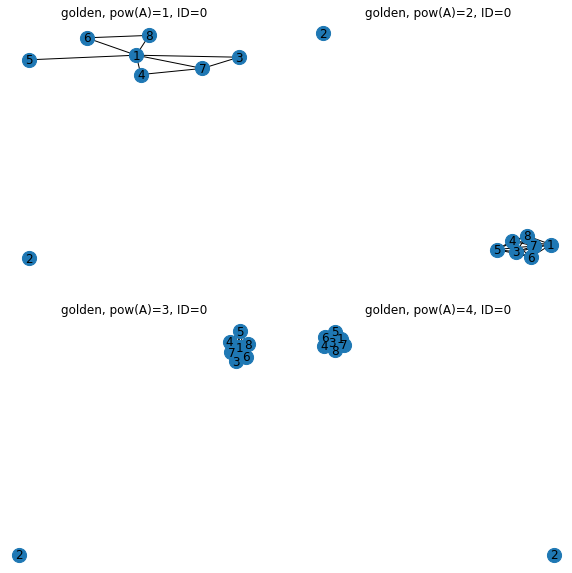

Plotting sample number: 2
Drawing Operator graph 1 of 4
Drawing Operator graph 2 of 4
Drawing Operator graph 3 of 4
Drawing Operator graph 4 of 4


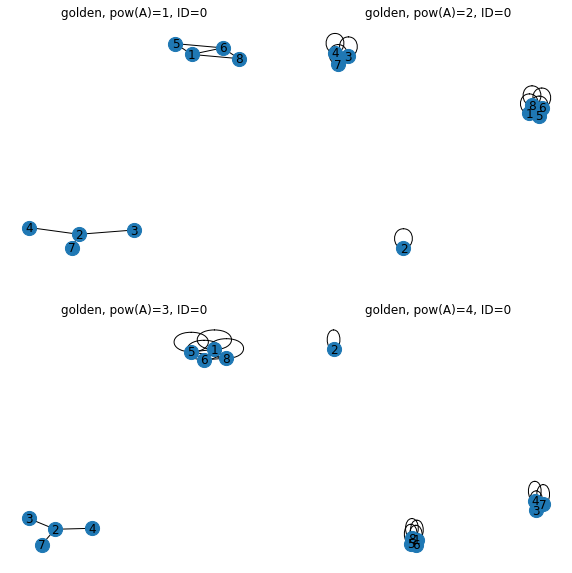

Plotting sample number: 3
Drawing Operator graph 1 of 4
Drawing Operator graph 2 of 4
Drawing Operator graph 3 of 4
Drawing Operator graph 4 of 4


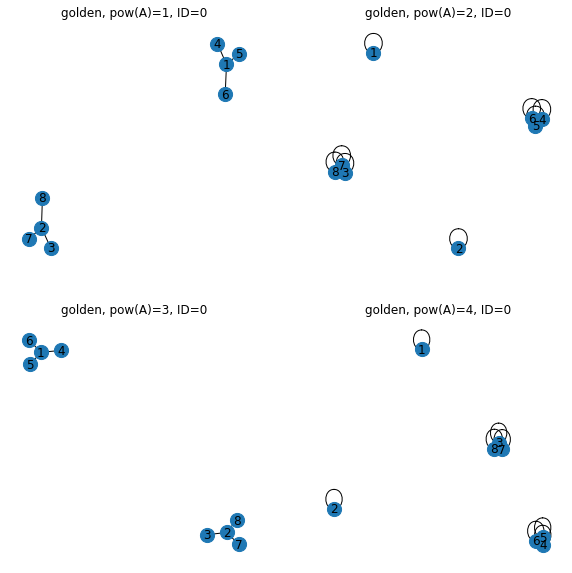

In [ ]:
viz_sign_operators(p=4, dataset_name='Cora', num_samples=3, seed=55, edge_weight_labels=False,
                       include_negative_samples=False, sign_type='golden', add_identity=False)

## Golden operators with p=4 operators, 3 randomly sampled links, with self loops added in A

Plotting for golden graphs. Num samples = 3, p = 4, seed = 55, edge_weight_labels = False, include_negative_samples = False, add_identity = True
Plotting sample number: 1
Drawing Operator graph 1 of 4
Drawing Operator graph 2 of 4
Drawing Operator graph 3 of 4
Drawing Operator graph 4 of 4


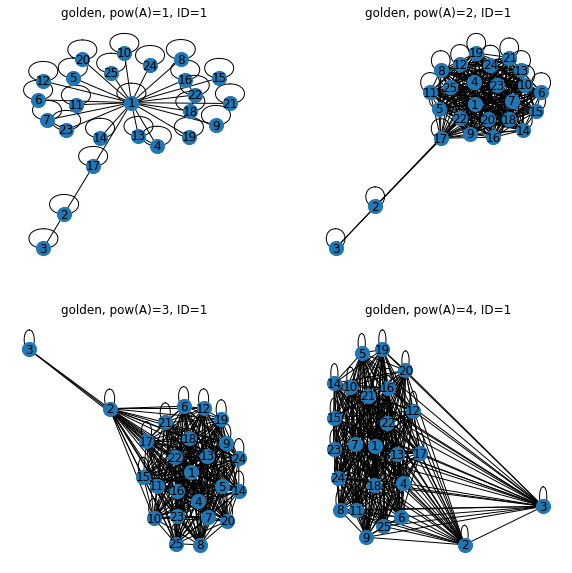

Plotting sample number: 2
Drawing Operator graph 1 of 4
Drawing Operator graph 2 of 4
Drawing Operator graph 3 of 4
Drawing Operator graph 4 of 4


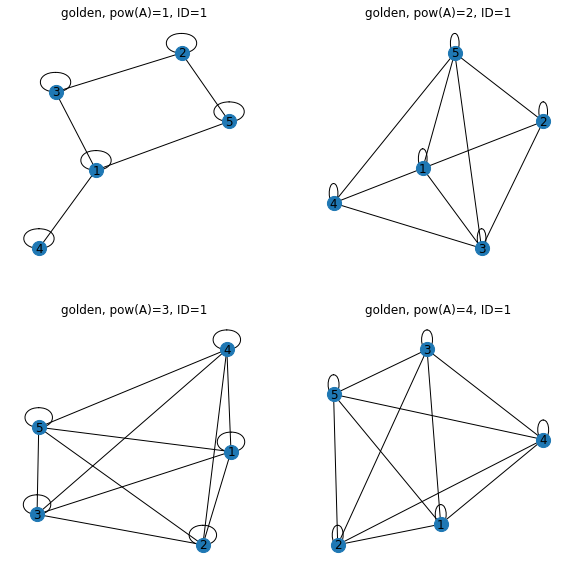

Plotting sample number: 3
Drawing Operator graph 1 of 4
Drawing Operator graph 2 of 4
Drawing Operator graph 3 of 4
Drawing Operator graph 4 of 4


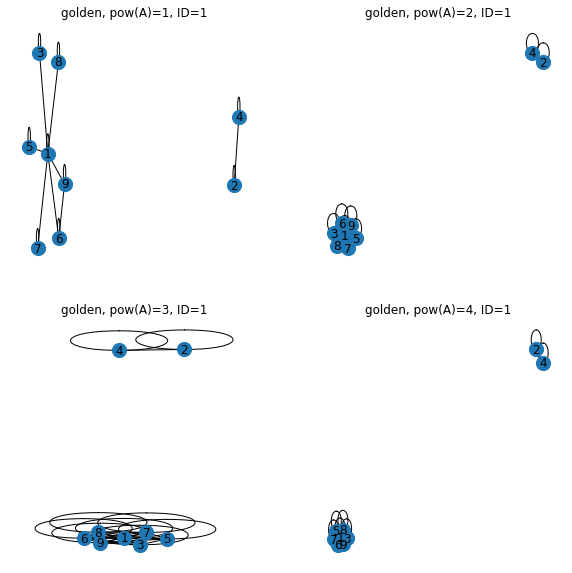

In [ ]:
viz_sign_operators(p=4, dataset_name='Cora', num_samples=3, seed=55, edge_weight_labels=False,
                       include_negative_samples=False, sign_type='golden', add_identity=True)

## Beagle operators with p=2 operators, 3 randomly sampled links, without self loops added in A

Beagle is less efficient than Golden due to increased number of k-hop subgraph extractions. To reduce the time to showcase the operators, we reduce p to 2.



Plotting for beagle graphs. Num samples = 3, p = 2, seed = 55, edge_weight_labels = False, include_negative_samples = False, add_identity = False
Plotting sample number: 1
Drawing Operator graph 1 of 2
Drawing Operator graph 2 of 2


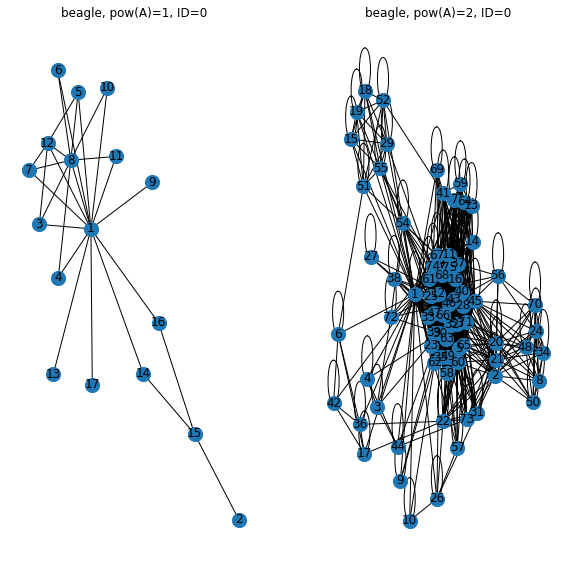

Plotting sample number: 2
Drawing Operator graph 1 of 2
Drawing Operator graph 2 of 2


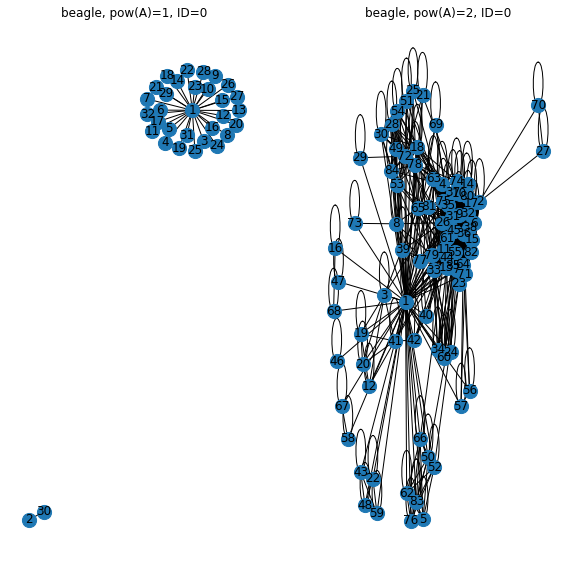

Plotting sample number: 3
Drawing Operator graph 1 of 2
Drawing Operator graph 2 of 2


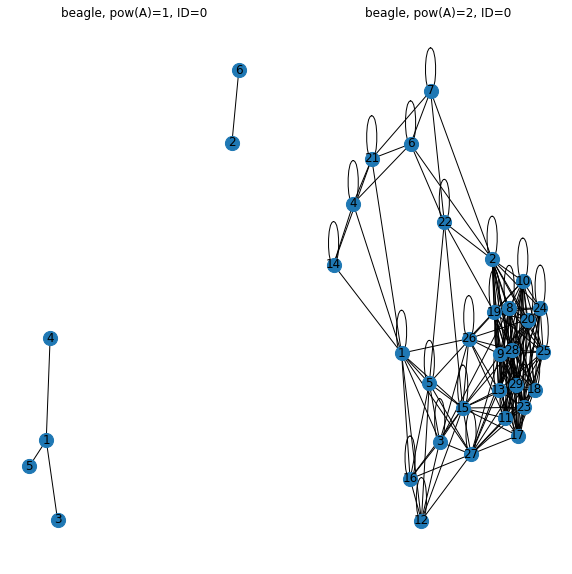

In [ ]:
viz_sign_operators(p=2, dataset_name='Cora', num_samples=3, seed=55, edge_weight_labels=False,
                       include_negative_samples=False, sign_type='beagle', add_identity=False)

## Beagle operators with p=2 operators, 3 randomly sampled links, with self loops added in A


Plotting for beagle graphs. Num samples = 3, p = 2, seed = 55, edge_weight_labels = False, include_negative_samples = False, add_identity = True
Plotting sample number: 1
Drawing Operator graph 1 of 2
Drawing Operator graph 2 of 2


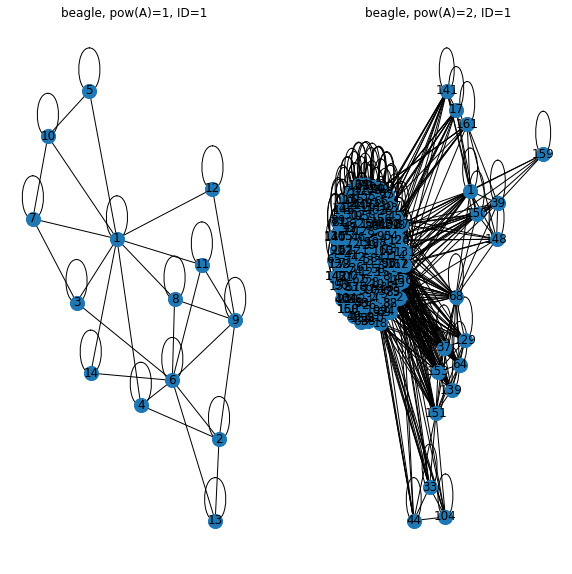

Plotting sample number: 2
Drawing Operator graph 1 of 2
Drawing Operator graph 2 of 2


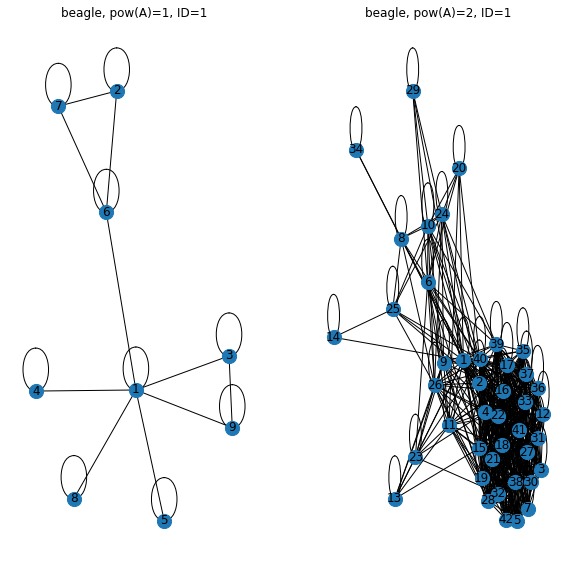

Plotting sample number: 3
Drawing Operator graph 1 of 2
Drawing Operator graph 2 of 2


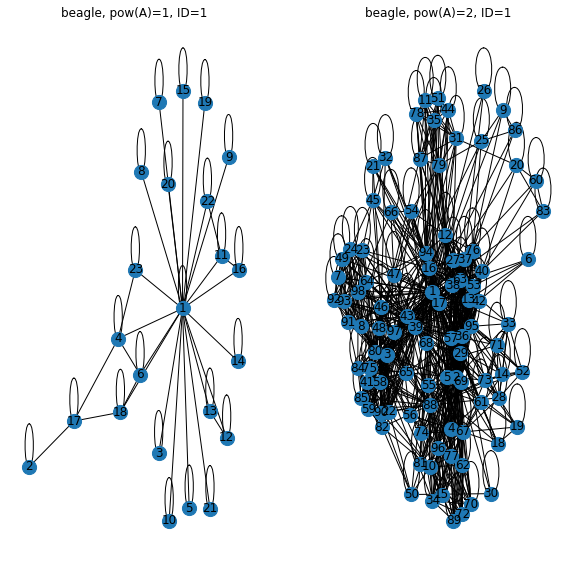

In [ ]:
viz_sign_operators(p=2, dataset_name='Cora', num_samples=3, seed=55, edge_weight_labels=False,
                       include_negative_samples=False, sign_type='beagle', add_identity=True)